In [1]:
from google.colab import drive
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.nasnet import NASNetMobile
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D 
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
#load the training data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def trainingSet(file_name):
    training_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
    return training_set  

In [0]:
#load the labels of one knee tear(abnormal | acl | meniscus) by the giving the file name that contains the labels
def load_labels(train_file_name, append_num):
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    label_list =  training_labels
    
    #repeat the labels "append_num - 1" times
    for i in range(append_num - 1):
        training_labels = np.concatenate((training_labels, label_list))
  
    return training_labels

In [0]:
#as each exam (stack) contains S slices and most of the pretrained CNN models accept the image with channel = 3
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [0]:
datagen = ImageDataGenerator(
        rotation_range = 5,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        zoom_range = 0.01,
        fill_mode='nearest')

In [0]:
#"data_augmentation" used to increase the size of the dataset and make some changes in the features of the data
#"datagen" take "batch_size" of the "dataset" and make some changes to this batch and return it to be stored
#the previous steb will be repeated until the new dataset size equals the size of the original data * "repeat_num"
def data_augmentation(dataset, repeat_num):
    augmented_data = []
    num_augmented = 0
    for X_batch in datagen.flow(dataset, batch_size= dataset.shape[0], shuffle=False):
        augmented_data.append(X_batch)
        num_augmented += dataset.shape[0]
        if num_augmented == dataset.shape[0] * repeat_num:
            break
          
    return np.array(augmented_data).reshape(num_augmented, 256, 256, 3)

In [9]:
#load INCEPTIONV3 pretrainned model from keras without the top layer &
#specify the shape of the input image as (256x256x3) 
mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))

#remove the last one
mri_InceptionV3.layers.pop()

#get the output of the INCEPTIONV# model "feature extraction" and add Dense layers so that the model is designed
#to classify our data
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, output = predictor)

modified_mri_InceptionV3.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [10]:
gc.collect()

16

In [0]:
#freeze the layers and unfreeze the rest:
for layer in modified_mri_InceptionV3.layers[40:]:
    layer.trainable = True 
    
for layer in modified_mri_InceptionV3.layers[:40]:
    layer.trainable = False
    
#the loss function is binary_crossentropy as our labels are binary(0|1)
#Adam optimizer use small learning rate(lr) to 
modified_mri_InceptionV3.compile(loss='binary_crossentropy', metrics=['accuracy'],
                 optimizer=Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0))

In [0]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    val_targ = self.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    print ('-val_f1 : %f '%(_val_f1))
    return
metrics = Metrics()

In [0]:
def plot_history(history):
  plt.figure(figsize=(8, 6))
  ax = plt.gca()
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='Loss')
  plt.plot(history.epoch, history.history['val_loss'], label='validation error')
  plt.plot(history.epoch, history.history['acc'], label='accuracy')
  plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
  plt.plot(metrics.val_f1s, label='f_score')
  plt.grid(True,color='white')
  mpl.style.use('seaborn')
  plt.legend() 
  

In [14]:
gc.collect()

553

In [0]:
#train the model with 2214 trainning data & 46 validation data
#save the model that has the min validation loss
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score 
def fit_model(training_set, training_labels, model_file_name):
  
    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.02,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1), metrics])
    plot_history(history)
    best_model = load_model(model_file_name)
    return best_model

In [0]:
#load the data labels for the abnormal tear
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv', 2)

#load the axial data, extract 3 slices from each exam & augment this data
training_set_axial = trainingSet('axial')
training_set_axial = extract_3(training_set_axial, 1130)
training_set_axial = data_augmentation(training_set_axial, 2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 42s 19ms/step - loss: 0.4172 - acc: 0.8261 - val_loss: 2.0794 - val_acc: 0.8696
-val_f1 : 0.930233 
Epoch 2/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.1797 - acc: 0.9255 - val_loss: 2.0794 - val_acc: 0.8696
-val_f1 : 0.930233 
Epoch 3/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0886 - acc: 0.9643 - val_loss: 2.3408 - val_acc: 0.8043
-val_f1 : 0.888889 
Epoch 4/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0652 - acc: 0.9765 - val_loss: 3.7469 - val_acc: 0.7391
-val_f1 : 0.846154 


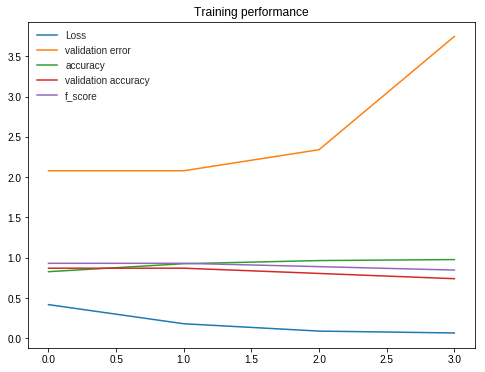

In [17]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an abnormal tear or not 
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "axial_abnormal_model")

In [0]:
del(training_label_abnormal)
gc.collect()

#load the data labels for the acl tear
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 20s 9ms/step - loss: 0.6054 - acc: 0.7958 - val_loss: 2.1024 - val_acc: 0.8696


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.1449 - acc: 0.9494 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 3/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0384 - acc: 0.9864 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 4/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0533 - acc: 0.9833 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 


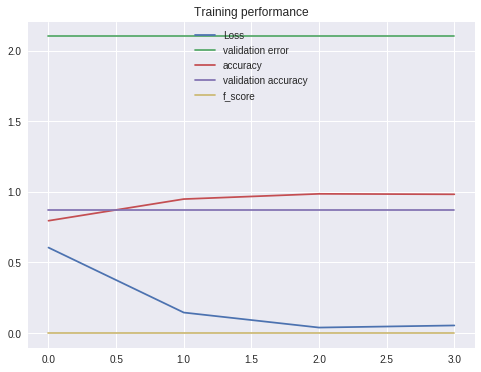

In [19]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an acl tear or not 
axial_acl_model = fit_model(training_set_axial, training_label_acl, "axial_acl_model")

In [0]:
del(training_label_acl)
gc.collect()

#load the data labels for the meniscus tear
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.6851 - acc: 0.7005 - val_loss: 6.3071 - val_acc: 0.6087


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.2720 - acc: 0.8799 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 
Epoch 3/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.1035 - acc: 0.9603 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 
Epoch 4/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.1067 - acc: 0.9612 - val_loss: 6.6150 - val_acc: 0.5435
-val_f1 : 0.000000 


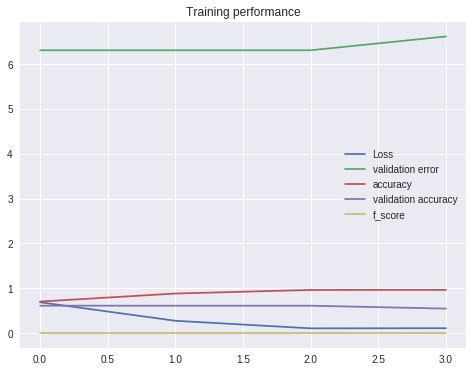

In [21]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has a meniscus tear or not 
axial_meniscus_model = fit_model(training_set_axial, training_label_meniscus, "axial_meniscus_model")

In [0]:
del(training_label_meniscus)
del(training_set_axial)
gc.collect()

#load the data labels for the abnormal tear
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv', 2)

#load the coronal data, extract 3 slices from each exam & augment this data
training_set_coronal = trainingSet('coronal')
training_set_coronal = extract_3(training_set_coronal, 1130)
training_set_coronal = data_augmentation(training_set_coronal, 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 20s 9ms/step - loss: 0.5443 - acc: 0.7918 - val_loss: 2.0795 - val_acc: 0.8696
-val_f1 : 0.930233 
Epoch 2/30
2214/2214 [==============================] - 20s 9ms/step - loss: 0.1849 - acc: 0.9286 - val_loss: 2.3734 - val_acc: 0.8478
-val_f1 : 0.917647 
Epoch 3/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0794 - acc: 0.9729 - val_loss: 2.1145 - val_acc: 0.8478
-val_f1 : 0.917647 
Epoch 4/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.0689 - acc: 0.9738 - val_loss: 10.0714 - val_acc: 0.3043
-val_f1 : 0.448276 


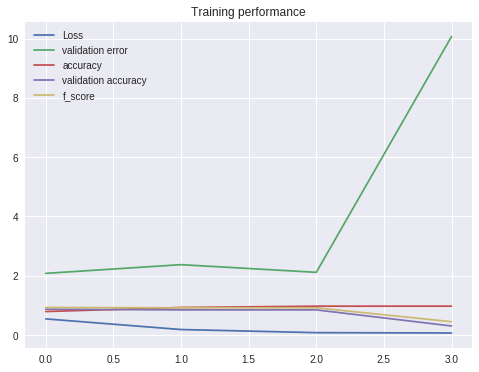

In [23]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an abnormal tear or not 
coronal_abnormal_model = fit_model(training_set_coronal, training_label_abnormal, "coronal_abnormal_model")

In [0]:
del(training_label_abnormal)
gc.collect()

#load the data labels for the acl tear
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.6430 - acc: 0.7827 - val_loss: 2.1024 - val_acc: 0.8696


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.3604 - acc: 0.8379 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 3/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.1910 - acc: 0.9264 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 4/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.0989 - acc: 0.9666 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 


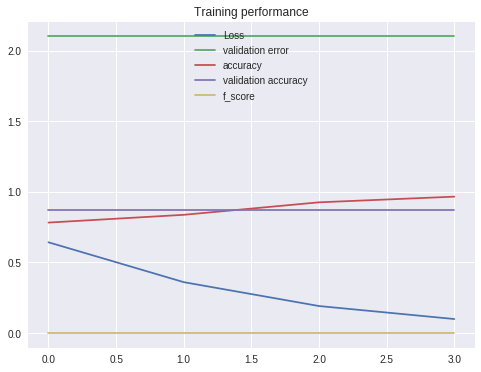

In [25]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an acl tear or not 
coronal_acl_model = fit_model(training_set_coronal, training_label_acl, "coronal_acl_model")

In [0]:
del(training_label_acl)
gc.collect()

#load the data labels for the meniscus tear
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.6598 - acc: 0.7037 - val_loss: 6.3071 - val_acc: 0.6087


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.3661 - acc: 0.8284 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 
Epoch 3/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.1782 - acc: 0.9345 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 
Epoch 4/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.1102 - acc: 0.9634 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 


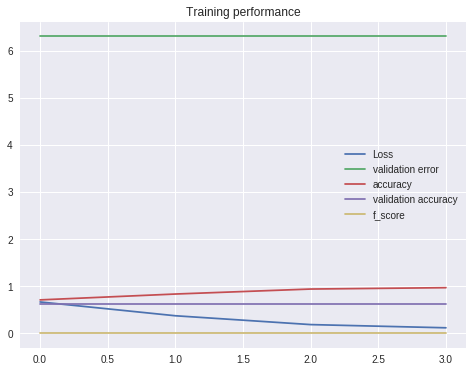

In [27]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has a meniscus tear or not 
coronal_meniscus_model = fit_model(training_set_coronal, training_label_meniscus, "coronal_meniscus_model")

In [0]:
del(training_label_meniscus)
del(training_set_coronal)
gc.collect()

#load the data labels for the abnormal tear
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv', 2)

#load the sagittal data, extract 3 slices from each exam & augment this data
training_set_sagittal = trainingSet('sagittal')
training_set_sagittal = extract_3(training_set_sagittal, 1130)
training_set_sagittal = data_augmentation(training_set_sagittal, 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.5142 - acc: 0.8035 - val_loss: 1.7484 - val_acc: 0.8696
-val_f1 : 0.930233 
Epoch 2/30
2214/2214 [==============================] - 21s 9ms/step - loss: 0.2341 - acc: 0.8952 - val_loss: 5.7002 - val_acc: 0.2609
-val_f1 : 0.320000 
Epoch 3/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.1072 - acc: 0.9593 - val_loss: 8.5094 - val_acc: 0.1739
-val_f1 : 0.240000 
Epoch 4/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.0522 - acc: 0.9797 - val_loss: 11.5741 - val_acc: 0.1304
-val_f1 : 0.130435 


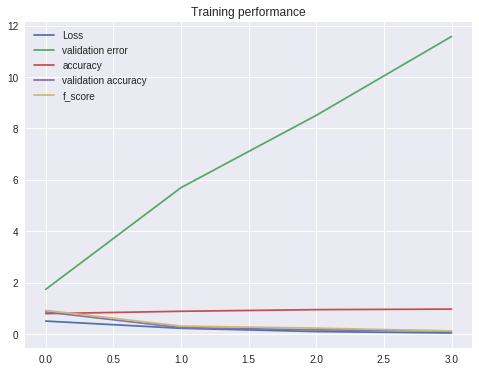

In [29]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an abnormal tear or not 
sagittal_abnormal_model = fit_model(training_set_sagittal, training_label_abnormal, "sagittal_abormal_model")

In [0]:
del(training_label_abnormal)
gc.collect()

#load the data labels for the acl tear
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.5940 - acc: 0.7895 - val_loss: 2.1024 - val_acc: 0.8696


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.2609 - acc: 0.8677 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 3/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.1651 - acc: 0.9359 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 
Epoch 4/30
2214/2214 [==============================] - 22s 10ms/step - loss: 0.0820 - acc: 0.9720 - val_loss: 2.1024 - val_acc: 0.8696
-val_f1 : 0.000000 


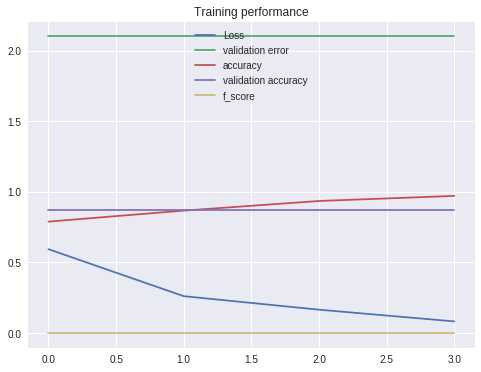

In [31]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an acl tear or not 
sagittal_acl_model = fit_model(training_set_sagittal, training_label_acl, "sagittal_acl_model")

In [0]:
del(training_label_acl)
gc.collect()

#load the data labels for the meniscus tear
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv', 2)

Train on 2214 samples, validate on 46 samples
Epoch 1/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.6581 - acc: 0.6906 - val_loss: 6.7667 - val_acc: 0.4130
-val_f1 : 0.571429 
Epoch 2/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.4353 - acc: 0.7927 - val_loss: 2.9578 - val_acc: 0.6087
-val_f1 : 0.608696 
Epoch 3/30
2214/2214 [==============================] - 22s 10ms/step - loss: 0.2849 - acc: 0.8681 - val_loss: 4.2076 - val_acc: 0.5652
-val_f1 : 0.523810 
Epoch 4/30
2214/2214 [==============================] - 22s 10ms/step - loss: 0.1781 - acc: 0.9309 - val_loss: 8.5339 - val_acc: 0.4348
-val_f1 : 0.518519 
Epoch 5/30
2214/2214 [==============================] - 22s 10ms/step - loss: 0.1321 - acc: 0.9526 - val_loss: 6.3071 - val_acc: 0.6087
-val_f1 : 0.000000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


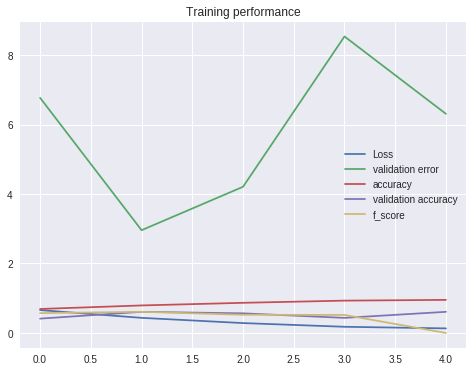

In [33]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has a meniscus tear or not 
sagittal_meniscus_model = fit_model(training_set_sagittal, training_label_meniscus, "sagittal_meniscus_model")

## Evaluate the 9 models

In [0]:
#load the test data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def testSet(file_name):
    test_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/valid/'+file_name+'/*.npy')):
        test_set.append(np.load(np_name))
    return test_set   

In [0]:
#load the test data for each angle of the knee
test_set_axial= testSet('axial')
test_set_coronal=testSet('coronal')
test_set_sagittal=testSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
test_set_axial = extract_3(test_set_axial, 120)
test_set_coronal =extract_3(test_set_coronal, 120)
test_set_sagittal =extract_3(test_set_sagittal, 120)

In [0]:
#load the labels of the test data for each knee tear 
test_label_abnormal = load_labels('MRNet-v1.0/valid-abnormal.csv', 1)
test_label_acl = load_labels('MRNet-v1.0/valid-acl.csv', 1)
test_label_meniscus = load_labels('MRNet-v1.0/valid-meniscus.csv', 1)

In [38]:
axial_abnormal_model.evaluate(test_set_axial, test_label_abnormal)

120/120 [==============================] - 44s 363ms/step


[3.321330364545206, 0.7916666666666666]

In [39]:
axial_acl_model.evaluate(test_set_axial, test_label_acl) 

120/120 [==============================] - 44s 369ms/step


[7.25314295574382, 0.55]

In [40]:
axial_meniscus_model.evaluate(test_set_axial, test_label_meniscus) 

120/120 [==============================] - 44s 366ms/step


[6.9845082867578165, 0.5666666666666667]

In [41]:
coronal_abnormal_model.evaluate(test_set_coronal, test_label_abnormal)

120/120 [==============================] - 45s 371ms/step


[3.3238882442315503, 0.775]

In [42]:
coronal_acl_model.evaluate(test_set_coronal, test_label_acl)

120/120 [==============================] - 44s 370ms/step


[7.25314295574382, 0.55]

In [43]:
coronal_meniscus_model.evaluate(test_set_coronal, test_label_meniscus)

120/120 [==============================] - 44s 370ms/step


[6.853271393396638, 0.5666666666666667]

In [44]:
sagittal_abnormal_model.evaluate(test_set_sagittal, test_label_abnormal)

120/120 [==============================] - 45s 377ms/step


[2.6245004099542713, 0.7916666666666666]

In [45]:
sagittal_acl_model.evaluate(test_set_sagittal, test_label_acl)

120/120 [==============================] - 45s 376ms/step


[7.25314295574382, 0.55]

In [46]:
sagittal_meniscus_model.evaluate(test_set_sagittal, test_label_meniscus)

120/120 [==============================] - 45s 378ms/step


[4.1824597676595054, 0.4749999980131785]

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an abnromal tear or not
#by doing a majority voting between the 3 models
def predict_abnormal(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_abnormal_prediction = axial_abnormal_model.predict(axial_input)
    coronal_abnormal_prediction = coronal_abnormal_model.predict(coronal_input)
    sagittal_abnormal_prediction = sagittal_abnormal_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_abnormal_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an acl tear or not
#by doing a majority voting between the 3 models
def predict_acl(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_acl_prediction = axial_acl_model.predict(axial_input)
    coronal_acl_prediction = coronal_acl_model.predict(coronal_input)
    sagittal_acl_prediction = sagittal_acl_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_acl_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an meniscus tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an meniscus tear or not
#by doing a majority voting between the 3 models
def predict_meniscus(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_meniscus_prediction = axial_meniscus_model.predict(axial_input)
    coronal_meniscus_prediction = coronal_meniscus_model.predict(coronal_input)
    sagittal_meniscus_prediction = sagittal_meniscus_model.predict(sagittal_input)
    
    #to say that the exam has the meniscus tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_meniscus_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_meniscus_model vote for the final decision 
        if(axial_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_meniscus_model vote for the final decision 
        if(coronal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_meniscus_model vote for the final decision 
        if(sagittal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [50]:
#evaluate the abnormal ensemble models
print (predict_abnormal(test_set_axial, test_set_coronal, test_set_sagittal, test_label_abnormal))

79.16666666666666


In [51]:
#evaluate the acl ensemble models
print (predict_acl(test_set_axial, test_set_coronal, test_set_sagittal, test_label_acl))

55.00000000000001


In [52]:
#evaluate the meniscus ensemble models
print (predict_meniscus(test_set_axial, test_set_coronal, test_set_sagittal, test_label_meniscus))

56.666666666666664
